In [1]:
import os
import vtk
import numpy as np
from vtk.util import numpy_support
from scipy.interpolate import interp1d

TARGET_N = 240

def resample_array(arr, target_len):
    original_len = len(arr)
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, arr, kind='linear', axis=0, fill_value="extrapolate")
    return f(x_new)

def read_vtk_point_cell_data(filepath):
    reader = vtk.vtkPolyDataReader()
    reader.SetFileName(filepath)
    reader.Update()
    polydata = reader.GetOutput()

    # 提取按连接顺序排列的坐标
    num_points = polydata.GetNumberOfPoints()
    num_lines = polydata.GetNumberOfLines()
    if num_lines != 1:
        raise ValueError(f"{filepath} contains {num_lines} lines (expected 1)")

    line = polydata.GetLines().GetData()
    line_np = numpy_support.vtk_to_numpy(line)
    line_point_ids = line_np[1:]
    coords = np.array([polydata.GetPoint(pid) for pid in line_point_ids])

    # 插值 coords
    resampled_coords = resample_array(coords, TARGET_N)

    # 插值 point data
    point_data = {}
    pd = polydata.GetPointData()
    for i in range(pd.GetNumberOfArrays()):
        array = pd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            if len(data) == len(coords):  # 只处理与 coords 长度一致的
                resampled = resample_array(data, TARGET_N)
                point_data[name] = resampled.astype(data.dtype)
            else:
                point_data[name] = data  # 保留不变

    # 不处理 cell_data，直接保留原始数据
    cell_data = {}
    cd = polydata.GetCellData()
    for i in range(cd.GetNumberOfArrays()):
        array = cd.GetArray(i)
        if array:
            name = array.GetName()
            data = numpy_support.vtk_to_numpy(array)
            cell_data[name] = data

    return point_data, cell_data, resampled_coords

def batch_read_vtk_data(directory):
    results = {}
    for fname in os.listdir(directory):
        if fname.lower().endswith(".vtk"):
            full_path = os.path.join(directory, fname)
            point_data, cell_data, coords = read_vtk_point_cell_data(full_path)
            results[fname] = {
                'point_data': point_data,
                'cell_data': cell_data,
                'coords': coords
            }
    return results

# 用法示例
base_dir = r"D:\!BraVa_src\ica_results\vmtkgeometry_91"
vtk_data_dict = batch_read_vtk_data(base_dir)

all_coords = [vtk_data_dict[name]["coords"] for name in vtk_data_dict]
coords_array = np.stack([vtk_data_dict[name]["coords"] for name in vtk_data_dict], axis=0)
# 所有曲线平移，使起点对齐到 [0, 0, 0]
coords_array = coords_array - coords_array[:, 0:1, :]
# 广播减法，coords_array[:, 0:1, :] shape 为 [N_samples, 1, 3]

In [2]:
for fname, content in vtk_data_dict.items():
    point_attrs = content['point_data']
    cell_attrs = content['cell_data']
    coords = content['coords']

    print(f"{fname}:")
    print(f"  Point attributes ({len(point_attrs)}): {list(point_attrs.keys())}")
    print(f"  Cell attributes ({len(cell_attrs)}): {list(cell_attrs.keys())}")
    print(f"  Points (coords): {coords.shape[0]}")
    print("-" * 60)


BG0001_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0001_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0003_L.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0003_R.vtk:
  Point attributes (5): ['Curvature', 'Torsion', 'FrenetTangent', 'FrenetNormal', 'FrenetBinormal']
  Cell attributes (2): ['Length', 'Tortuosity']
  Points (coords): 240
------------------------------------------------------------
BG0004_L.vtk:
  

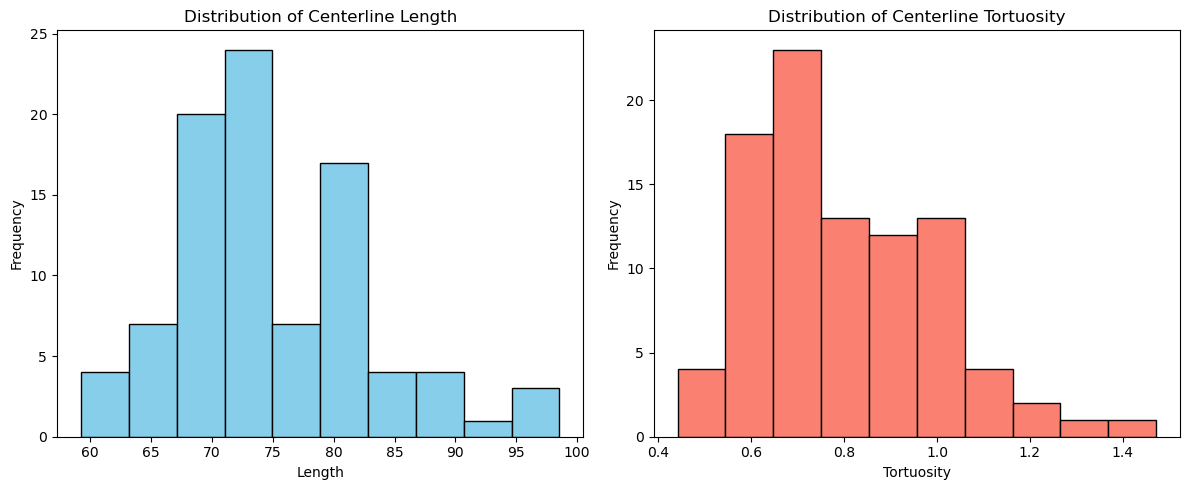

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 收集所有 length 和 tortuosity 数据
all_lengths = []
all_torts = []

for content in vtk_data_dict.values():
    cell_data = content['cell_data']
    if 'Length' in cell_data and 'Tortuosity' in cell_data:
        all_lengths.extend(cell_data['Length'])
        all_torts.extend(cell_data['Tortuosity'])

all_lengths = np.array(all_lengths)
all_torts = np.array(all_torts)

# 绘图
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(all_lengths, bins=10, color='skyblue', edgecolor='black')
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Distribution of Centerline Length")

plt.subplot(1, 2, 2)
plt.hist(all_torts, bins=10, color='salmon', edgecolor='black')
plt.xlabel("Tortuosity")
plt.ylabel("Frequency")
plt.title("Distribution of Centerline Tortuosity")

plt.tight_layout()
plt.show()


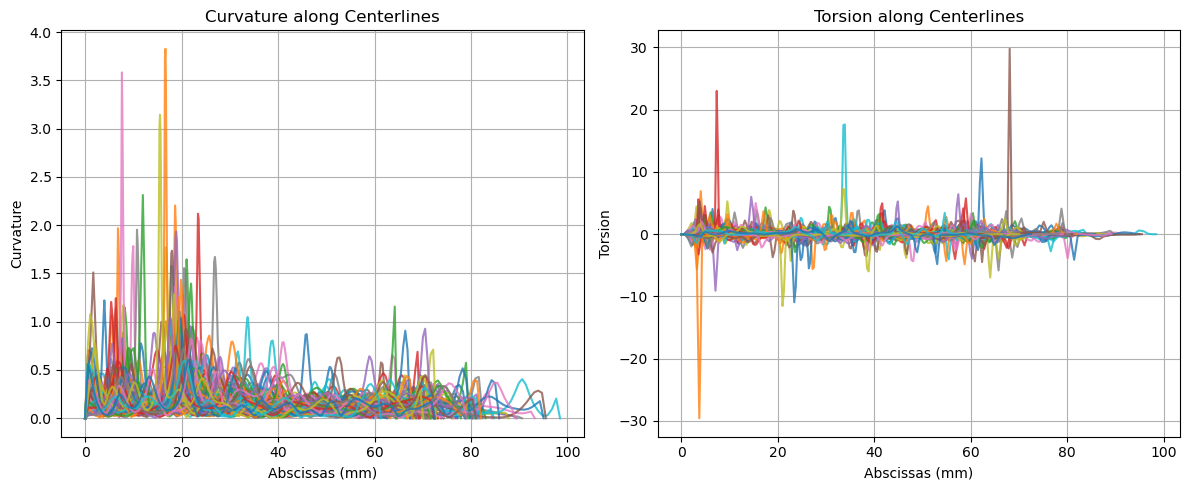

In [4]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# curvature subplot
plt.subplot(1, 2, 1)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Curvature' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Curvature'], label=fname, alpha=0.8)
plt.title("Curvature along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Curvature")
plt.grid(True)

# torsion subplot
plt.subplot(1, 2, 2)
for fname, content in vtk_data_dict.items():
    coords = content['coords']
    pdata = content['point_data']
    if 'Torsion' in pdata:
        diffs = np.linalg.norm(np.diff(coords, axis=0), axis=1)
        arc_length = np.concatenate([[0], np.cumsum(diffs)])
        plt.plot(arc_length, pdata['Torsion'], label=fname, alpha=0.8)
plt.title("Torsion along Centerlines")
plt.xlabel("Abscissas (mm)")
plt.ylabel("Torsion")
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
from io import StringIO
import sys
import re
import csv

class OutputCatcher:
    def __init__(self):
        self._stdout = sys.stdout
        self.buffer = StringIO()

    def __enter__(self):
        sys.stdout = self.buffer
        return self

    def __exit__(self, *args):
        sys.stdout = self._stdout

    def get(self):
        return self.buffer.getvalue()

def parse_alignment_log(log_text):
    pattern_iter = re.compile(r"(updating step: r=|Iteration )(\d+)")
    pattern_residual = re.compile(r"Residual(?: Change)?: ([\d\.]+)")
    pattern_energy = re.compile(r"Residual Energy: ([\d\.]+)")

    results = {}
    current_iter = None

    for line in log_text.splitlines():
        iter_match = pattern_iter.search(line)
        if iter_match:
            current_iter = int(iter_match.group(2))
            if current_iter not in results:
                results[current_iter] = {'iter': current_iter}

        res_match = pattern_residual.search(line)
        if res_match and current_iter is not None:
            results[current_iter]['residual'] = float(res_match.group(1))

        ene_match = pattern_energy.search(line)
        if ene_match and current_iter is not None:
            results[current_iter]['energy'] = float(ene_match.group(1))

    # 转成列表并排序
    return [results[k] for k in sorted(results)]


def write_log_to_csv(results, filename):
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=["iter", "residual", "energy"])
        writer.writeheader()
        writer.writerows(results)
    print(f"[log] Wrote {len(results)} rows to {filename}")


[log] Wrote 20 rows to ./alignment_plain.csv
[log] Wrote 20 rows to ./alignment_weighted.csv


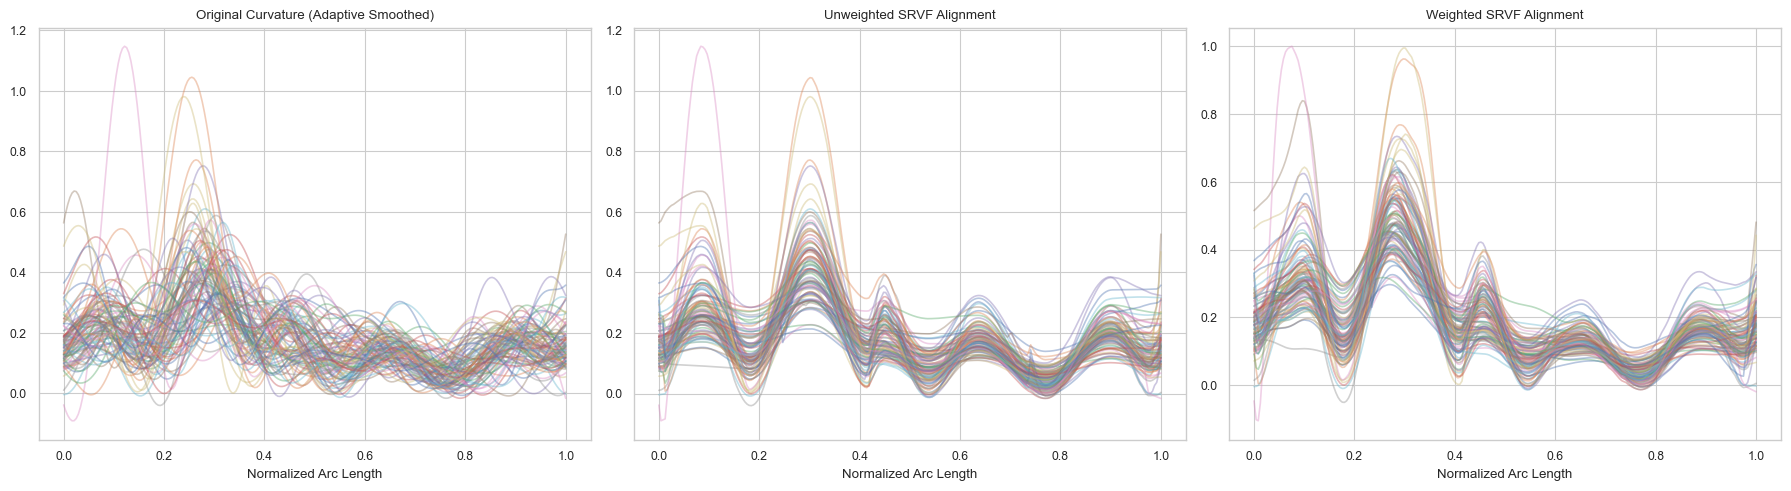

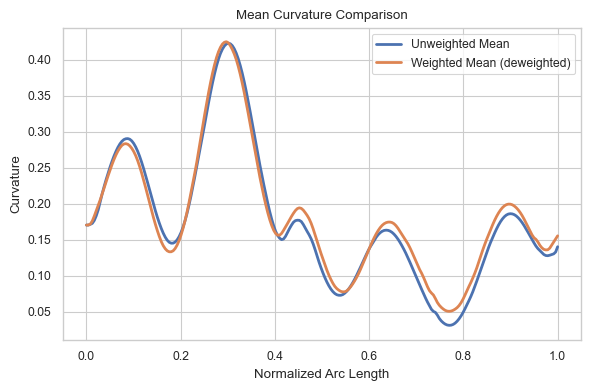

(240,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
from scipy.signal import find_peaks
from fdasrsf.utility_functions import resamplefunction
from fdasrsf.time_warping import fdawarp
import seaborn as sns

sns.set(style="whitegrid", context="paper", font_scale=1)
# 参数
# # target_len = 200
# target_len = 500  # 目标长度
t_resample = np.linspace(0, 1, TARGET_N )
alpha_s = 0.75

# Fourier 平滑函数
def fourier_lowpass(signal, keep_ratio):
    N = len(signal)
    fhat = fft(signal)
    keep = int(N * keep_ratio)
    fhat[keep:-keep] = 0
    return np.real(ifft(fhat))

# 自适应平滑函数：使平滑后曲线具有约 5 个峰
def adaptive_fourier_smoothing(signal, peak_target=5, tol=1, max_iter=50):
    ratios = np.linspace(0.01, 0.2, 100)
    for r in ratios:
        smoothed = fourier_lowpass(signal, keep_ratio=r)
        peaks, _ = find_peaks(smoothed,
                                prominence=(np.max(smoothed) - np.min(smoothed)) * 0.08,
                                distance=TARGET_N  // 10  # 避免过密峰值
                            )
        if abs(len(peaks) - peak_target) <= tol:
            return smoothed
    return fourier_lowpass(signal, keep_ratio=0.03)

# 结构权重函数（使用自适应傅立叶平滑）
def composite_weight(curves, alpha_s=0.75):
    """
    使用 adaptive Fourier smoothing 后的结构强度生成逐点加权权重。
    - curves: ndarray of shape [T, N]
    - alpha_s: 放大系数（越大越强调曲率突变区域）
    
    返回:
        weights: ndarray of shape [T, N]
    """
    T, N = curves.shape

    # Step 1: 对每条曲线使用 adaptive smoothing
    smoothed_curves = np.stack([
        adaptive_fourier_smoothing(curves[:, i], peak_target=5, tol=1)
        for i in range(N)
    ], axis=1)

    # Step 2: 局部结构强度（曲率绝对值）
    mag = np.abs(smoothed_curves)

    # Step 3: 一致性系数（强调 across-curves 一致的区域）
    consistency = 1.0 / (np.std(smoothed_curves, axis=1) + 1e-5)
    consistency = (consistency - consistency.min()) / (consistency.max() - consistency.min() + 1e-8)
    consistency = consistency[:, None]  # shape [T, 1]

    # Step 4: 综合权重计算
    weights = (1 + alpha_s * mag) * (0.5 + 0.5 * consistency)

    # Step 5: 全局归一化
    weights /= (weights.mean() + 1e-8)

    return weights  # shape [T, N]


# 主流程
names = list(vtk_data_dict.keys())
resampled_curves = []

for name in names:
    curvature = vtk_data_dict[name]["point_data"]["Curvature"]
    coords = vtk_data_dict[name]["coords"]

    # 不再重新插值，只保留 smoothing（输入已经是500点）
    curvature = adaptive_fourier_smoothing(curvature, peak_target=5, tol=1)
    resampled_curves.append(curvature)


f = np.stack(resampled_curves).T
time = t_resample

# # 不加权对齐
with OutputCatcher() as capture_plain:
    obj_plain = fdawarp(f.copy(), time)
    obj_plain.srsf_align(parallel=True, MaxItr=20, verbose=True)

plain_log = capture_plain.get()
plain_results = parse_alignment_log(plain_log)
write_log_to_csv(plain_results, "./alignment_plain.csv")

# 加权对齐
W = composite_weight(f, alpha_s=alpha_s)
obj_weighted = fdawarp(f.copy(), time)
obj_weighted.custom_weights = W.mean(axis=0)  # 向自定义方法传权重
alpha_init = 0.05
# momentum_beta = 0.9
momentum_beta1= 0.9
momentum_beta2 = 0.999

with OutputCatcher() as capture_weighted:
    obj_weighted.srsf_align_weighted(
        pointwise_weights=W,
        MaxItr=20,
        parallel=True,
        alpha=alpha_init,
        use_momentum=True,
        beta1=momentum_beta1,
        beta2=momentum_beta2
    )

weighted_log = capture_weighted.get()
weighted_results = parse_alignment_log(weighted_log)
write_log_to_csv(weighted_results, "./alignment_weighted.csv")


# 恢复加权后数据
f_weighted_unwrapped = obj_weighted.fn / W
# f_weighted_unwrapped = obj_weighted.fn

# 可视化
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
for i in range(f.shape[1]):
    plt.plot(time, f[:, i], alpha=0.4)
plt.title("Original Curvature (Adaptive Smoothed)")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 2)
for i in range(f.shape[1]):
    plt.plot(time, obj_plain.fn[:, i], alpha=0.4)
plt.title("Unweighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.subplot(1, 3, 3)
for i in range(f.shape[1]):
    plt.plot(time, f_weighted_unwrapped[:, i], alpha=0.4)
plt.title("Weighted SRVF Alignment")
plt.xlabel("Normalized Arc Length")
plt.grid(True)

plt.tight_layout()
plt.show()

# 平均曲率比较
plt.figure(figsize=(6, 4))
plt.plot(time, obj_plain.fmean, label='Unweighted Mean', lw=2)
plt.plot(time, obj_weighted.fmean, label='Weighted Mean (deweighted)', lw=2)
plt.xlabel("Normalized Arc Length")
plt.ylabel("Curvature")
plt.title("Mean Curvature Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

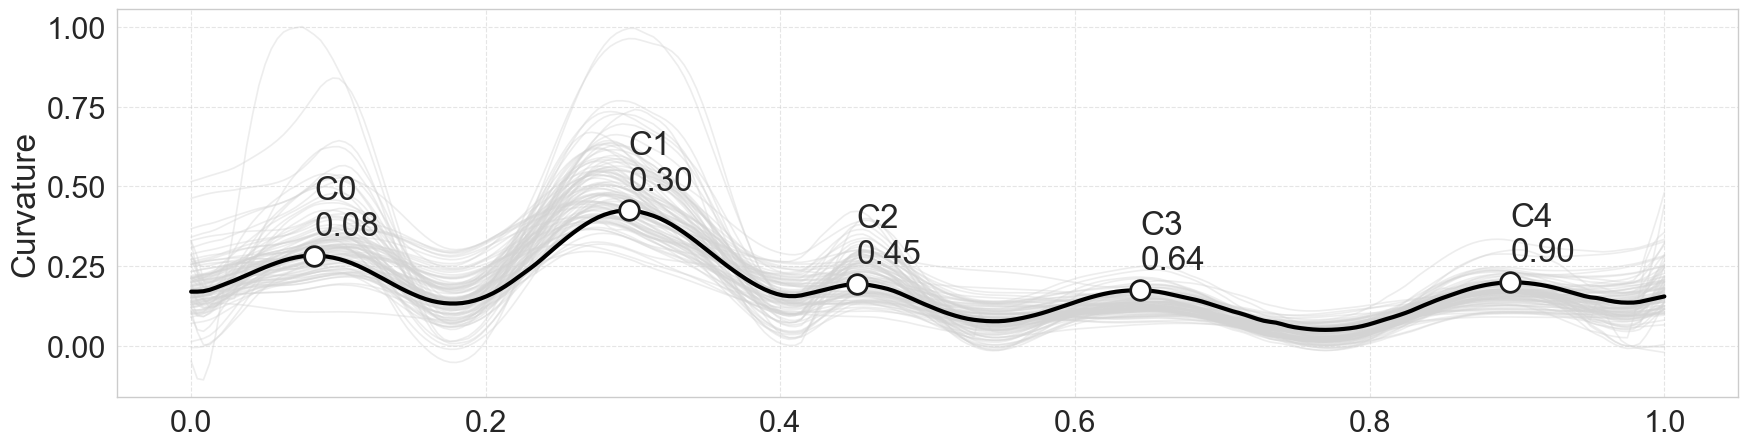

In [7]:
import seaborn as sns
from scipy.signal import find_peaks

sns.set(style="whitegrid", context="paper", font_scale=2.5)

# 计算去权重后的平均曲线
# mean_curve = obj_weighted.fmean / W.mean(axis=1)
mean_curve = obj_weighted.fmean

# 寻找峰值点
peaks, _ = find_peaks(
    mean_curve,
    prominence=(np.max(mean_curve) - np.min(mean_curve)) * 0.08,  # 自适应prominence
    distance=TARGET_N // 10                                     # 控制峰值间距（25点）
)

# 将峰值按 x 坐标排序（从左到右）
sorted_peaks = peaks[np.argsort(time[peaks])]

# 可视化
fig = plt.figure(figsize=(18, 5))
ax = fig.add_subplot(111)

# 所有对齐曲线
for i in range(f.shape[1]):
    ax.plot(time, f_weighted_unwrapped[:, i], alpha=0.4, color='lightgray')

# 平均曲线
ax.plot(time, mean_curve, label='Weighted Mean (deweighted)', lw=3, color='black')

# 标注峰值
ax.scatter(time[sorted_peaks], mean_curve[sorted_peaks],
           color='white', edgecolors='k', linewidths=2,
           s=200, zorder=10, label='Peaks')

# 添加标注文字 C0 ~ Cn 和对应高度
for i, idx in enumerate(sorted_peaks):
    peak_x = time[idx]
    peak_y = mean_curve[idx]
    ax.annotate(f"C{i}\n{peak_x:.2f}", xy=(peak_x, peak_y),
                xytext=(0, 10), textcoords='offset points',
                ha='left', va='bottom', fontsize=24,
                arrowprops=dict(arrowstyle='-', lw=1))

# 标签和网格
ax.set_ylabel("Curvature")
plt.grid(linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.legend()
plt.show()


PC1: Variance = 0.5666, Cumulative = 0.5666
PC2: Variance = 0.2159, Cumulative = 0.7825
PC3: Variance = 0.1090, Cumulative = 0.8915


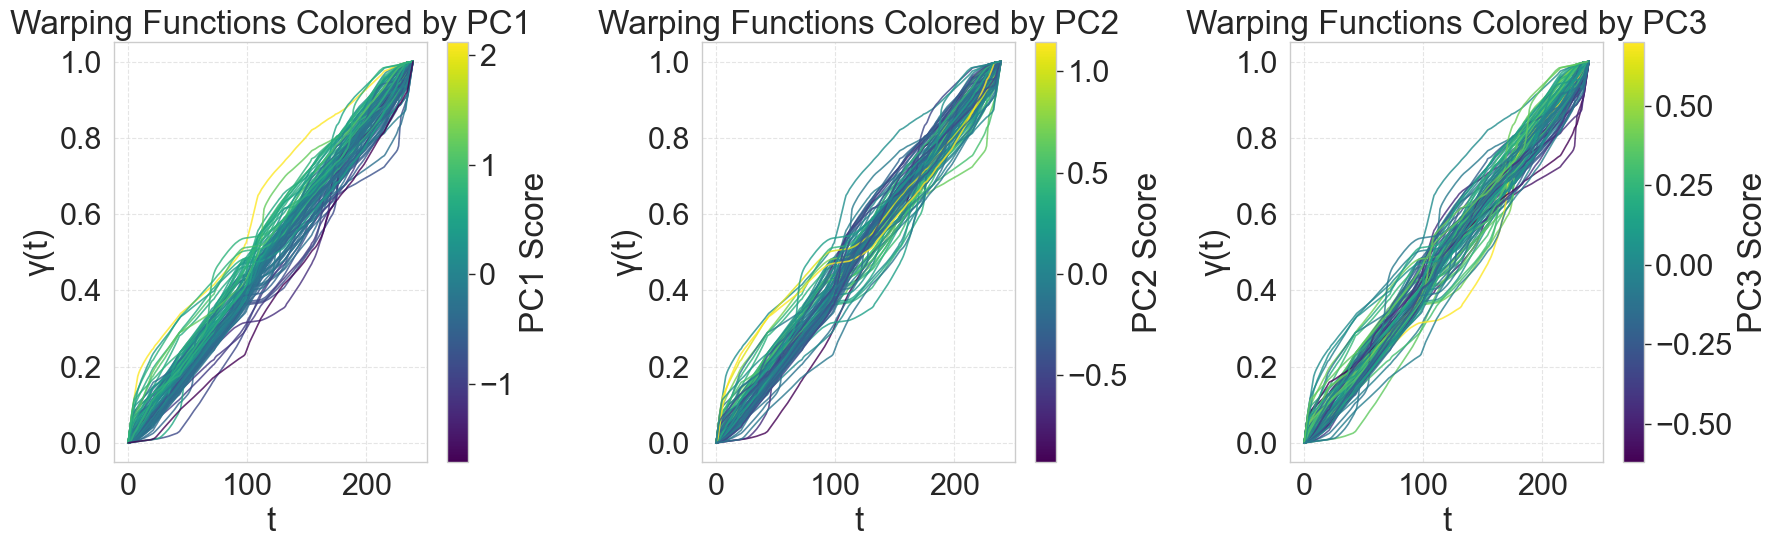

Labels (0–7 classes):
[3 0 4 1 7 6 0 5 0 4 2 2 4 5 2 4 4 4 1 1 0 7 4 5 3 3 7 1 0 0 5 3 2 4 6 0 5
 2 1 2 4 0 0 0 3 5 4 5 6 7 3 3 7 0 5 0 2 0 0 5 4 2 5 4 0 0 1 3 0 5 2 1 1 6
 7 5 5 2 0 6 1 1 7 0 7 0 5 6 0 7 0]


In [8]:
from sklearn.decomposition import PCA
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np

# PCA
pca = PCA(n_components=3)
X = obj_weighted.gam.T
X_pca = pca.fit_transform(X)

# 累计寄与率
explained = pca.explained_variance_ratio_
cumulative_explained = np.cumsum(explained)

# 输出
for i, (var, cum) in enumerate(zip(explained, cumulative_explained)):
    print(f"PC{i+1}: Variance = {var:.4f}, Cumulative = {cum:.4f}")


fig, axs = plt.subplots(1, 3, figsize=(18, 6))
pcs = ['PC1', 'PC2', 'PC3']
cmap = cm.viridis

for j in range(3):
    pc_values = X_pca[:, j]
    norm = Normalize(vmin=np.min(pc_values), vmax=np.max(pc_values))

    for i in range(X.shape[0]):
        axs[j].plot(obj_weighted.gam[:, i],
                    color=cmap(norm(pc_values[i])),
                    alpha=0.8)

    axs[j].set_title(f"Warping Functions Colored by {pcs[j]}")
    axs[j].set_xlabel("t")
    axs[j].set_ylabel("γ(t)")
    axs[j].grid(True, linestyle='--', alpha=0.5)

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axs[j])
    cbar.set_label(f"{pcs[j]} Score")

plt.tight_layout()
plt.show()


import numpy as np
from sklearn.decomposition import PCA

# 计算每个 PC 的均值
pc_means = X_pca.mean(axis=0)  # shape: (3,)

# 比较每个样本的每个 PC 是否大于均值
binary_flags = (X_pca > pc_means).astype(int)  # shape: (n_samples, 3)

# 将每行的三个 0/1 编码转为 0–7 的整数标签（PC1 为高位）
labels = binary_flags[:, 0] * 4 + binary_flags[:, 1] * 2 + binary_flags[:, 2]

# 输出 labels（长度等于样本数）
print("Labels (0–7 classes):")
print(labels)


C:\Users\cheno\AppData\Local\Temp\ipykernel_28272\10038063.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', 8)


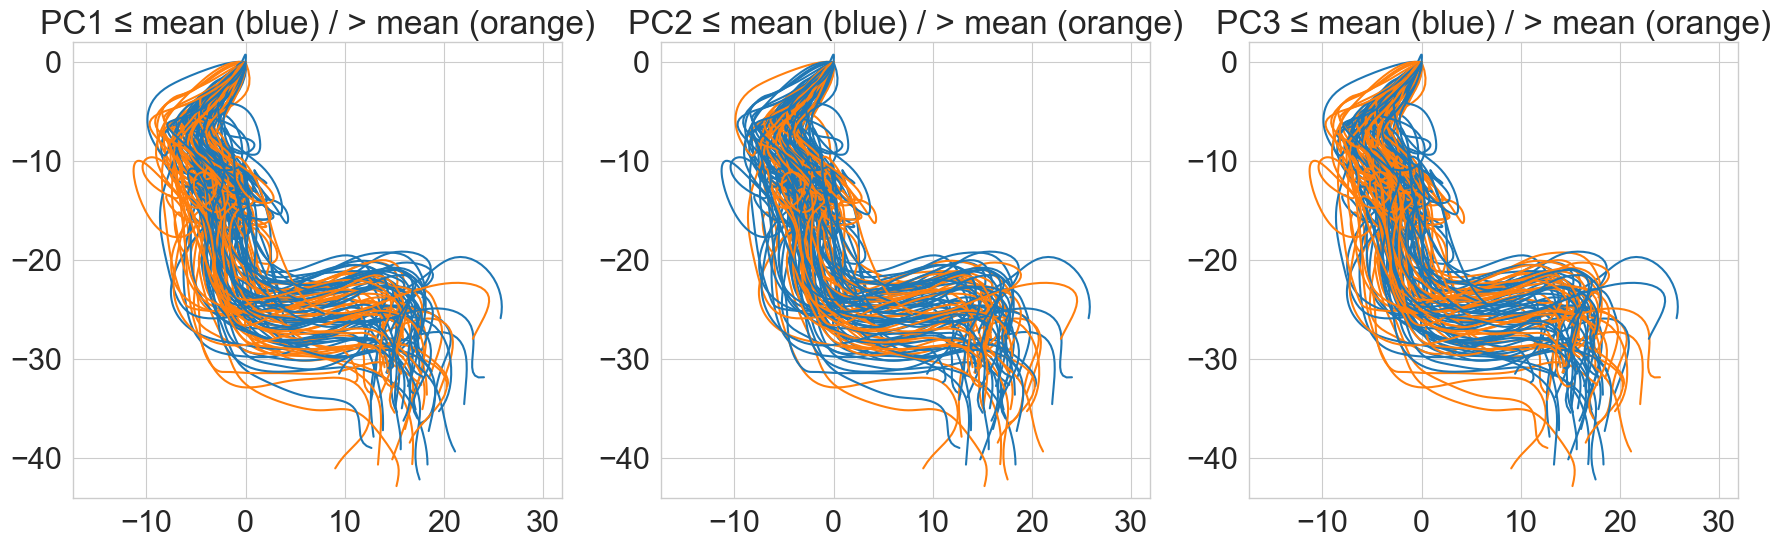

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# 假设你已有：
# - coords_array: list of (N, 3) arrays
# - labels: array of shape (n_samples,) with values in 0–7
# - X_pca: PCA投影后的 (n_samples, 3) 数据

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 构造颜色映射（最多8类，取colormap前8个颜色）
cmap = cm.get_cmap('tab10', 8)
colors = [cmap(i) for i in range(8)]

# 图1：按 PC1 分
for i in range(len(coords_array)):
    pc1_group = (labels[i] & 4) >> 2  # 取第1位（高位）
    axs[0].plot(coords_array[i][:, 0], coords_array[i][:, 1],
                color=colors[pc1_group], linewidth=1.5)
axs[0].set_title("PC1 ≤ mean (blue) / > mean (orange)")
axs[0].axis("equal")
axs[0].grid(True)

# 图2：按 PC2 分
for i in range(len(coords_array)):
    pc2_group = (labels[i] & 2) >> 1  # 取第2位
    axs[1].plot(coords_array[i][:, 0], coords_array[i][:, 1],
                color=colors[pc2_group], linewidth=1.5)
axs[1].set_title("PC2 ≤ mean (blue) / > mean (orange)")
axs[1].axis("equal")
axs[1].grid(True)

# 图3：按 PC3 分
for i in range(len(coords_array)):
    pc3_group = (labels[i] & 1)  # 取第3位
    axs[2].plot(coords_array[i][:, 0], coords_array[i][:, 1],
                color=colors[pc3_group], linewidth=1.5)
axs[2].set_title("PC3 ≤ mean (blue) / > mean (orange)")
axs[2].axis("equal")
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [10]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from scipy.stats import linregress
from scipy.stats import pearsonr
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.signal import find_peaks
from matplotlib import cm
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import norm
from AngioMorphPCA.make_figures import set_x_ticks_normalized
import fdasrsf as fs
from sklearn.svm import SVC
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, cross_val_score
from skimage import measure
import vtk
import pandas as pd

from scipy.ndimage import gaussian_filter
sns.set_context('notebook', font_scale=1.2)
from scipy.integrate import simps


def preprocess_open_curve(curve, target_k=100):
    """
    对3D开曲线进行标准化处理：
    - 起点对齐
    - 重采样为 target_k+1 个点（以便后续删去起点）
    - 缩放为单位弧长
    - 去除首点（避免 SRVMetric 奇异）

    返回：
    - processed_curve: 长度为1的统一曲线 (target_k, 3)，不含首点
    - original_length: 原始长度（用于逆缩放）
    """
    # 起点平移
    curve = curve - curve[0]

    # 原始参数化（基于弧长）
    diffs = np.diff(curve, axis=0)
    seg_lengths = np.linalg.norm(diffs, axis=1)
    cumlen = np.concatenate([[0], np.cumsum(seg_lengths)])
    t_orig = cumlen / cumlen[-1]
    original_length = cumlen[-1]

    # 重采样为 target_k+1 个点
    t_target = np.linspace(0, 1, target_k + 1)
    interp = interp1d(t_orig, curve, axis=0, kind='linear')
    resampled = interp(t_target)

    # 缩放为单位弧长
    resampled /= original_length

    # 删除首点（确保满足 DiscreteCurvesStartingAtOrigin 要求）
    processed_curve = resampled[1:]

    return processed_curve, original_length


tPCA_N_COMPONENTS = 16

k_sampling_points = TARGET_N # TARGET_N=240
# curve_cs = coords_array.copy()
curve_cs = []
for coords in coords_array:
    # 对每条曲线进行预处理
    preprocessed_curve, preprocessed_curve_length = preprocess_open_curve(coords, target_k=k_sampling_points)
    curve_cs.append(preprocessed_curve)
curve_cs = np.array(curve_cs)
print (curve_cs.shape)


(91, 240, 3)


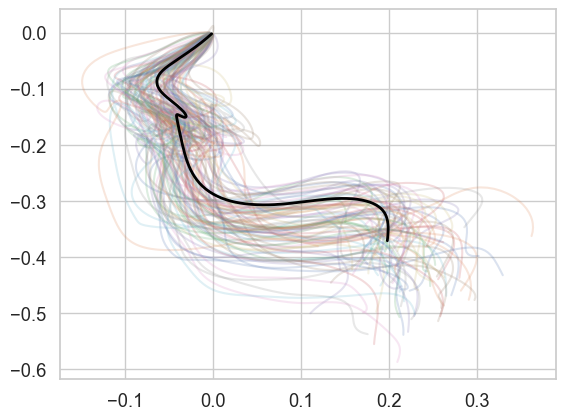

In [11]:
curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points+1, equip=False
)
curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)
mean_estimate = mean.estimate_

for i in range(len(curve_cs)):
    plt.plot(curve_cs[i][:, 0], curve_cs[i][:, 1],alpha=0.2)
plt.plot(mean_estimate[:, 0], mean_estimate[:, 1], color='black', linewidth=2, label='Frechet Mean')
plt.show()

tangent_base = mean.estimate_

tpca = TangentPCA(curves_r3, n_components=tPCA_N_COMPONENTS)
tpca.fit(curve_cs, base_point=tangent_base)
tangent_projected_data = tpca.transform(curve_cs)

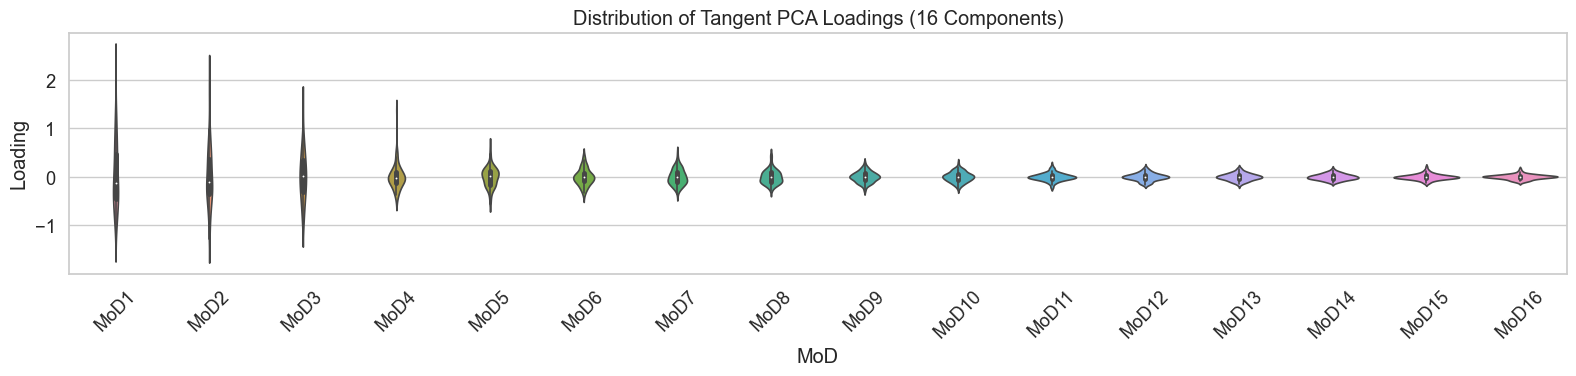

In [12]:
# 构建DataFrame以便使用seaborn绘图
n_components = tangent_projected_data.shape[1]
df = pd.DataFrame(tangent_projected_data, columns=[f"MoD{i+1}" for i in range(n_components)])

# 转换为long-form格式以便violinplot
df_long = df.melt(var_name="MoD", value_name="Loading")

# 绘制violin图
plt.figure(figsize=(16, 4))
sns.violinplot(data=df_long, x="MoD", y="Loading", inner="box", linewidth=1.2)
plt.title("Distribution of Tangent PCA Loadings (16 Components)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from geomstats.geometry.discrete_curves import DiscreteCurvesStartingAtOrigin, SRVMetric
from geomstats.learning.frechet_mean import FrechetMean

# 参数设定
pc_index = 0
scores = tangent_projected_data[:, pc_index]
threshold = np.median(scores)

# 根据 PC1 分组
high_group = curve_cs[scores > threshold]
low_group = curve_cs[scores <= threshold]

# 分别构建 manifold 对象（每组要单独构建，因为 manifold 中缓存了采样点数）
curves_r3_pc1_high = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=high_group.shape[1], equip=False
)
curves_r3_pc1_high.equip_with_metric(SRVMetric)

curves_r3_pc1_low = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=low_group.shape[1], equip=False
)
curves_r3_pc1_low.equip_with_metric(SRVMetric)

# 分别计算 Frechet Mean
mean_high = FrechetMean(curves_r3_pc1_high)
mean_high.fit(high_group)
mean_high_curve = mean_high.estimate_

mean_low = FrechetMean(curves_r3_pc1_low)
mean_low.fit(low_group)
mean_low_curve = mean_low.estimate_


diff = mean_high_curve - mean_low_curve
euclidean_diff_norm = np.linalg.norm(diff, axis=1)
total_diff = np.sum(euclidean_diff_norm) / len(euclidean_diff_norm)
print(f"Average Euclidean norm between mean curves: {total_diff:.6f}")

pca = PCA(n_components=3)
pca.fit(diff)

print("Explained variance ratio (directionality of shape change):", pca.explained_variance_ratio_)
print("Principal direction of shape difference (1st PC):", pca.components_[0])

import numpy as np
import plotly.graph_objects as go
from sklearn.decomposition import PCA

# 计算差值和主方向
diff = mean_high_curve - mean_low_curve
pca = PCA(n_components=3)
pca.fit(diff)
principal_direction = pca.components_[0]  # shape: (3,)

# 设置箭头的起点为 mean_low_curve 的中点
center_idx = len(mean_low_curve) // 2
arrow_start = mean_low_curve[center_idx]
arrow_dir = principal_direction * 0.1  # 调整长度以便可视化
arrow_end = arrow_start + arrow_dir

# 创建图形
fig = go.Figure()

# 添加平均曲线
fig.add_trace(go.Scatter3d(
    x=mean_low_curve[:, 0], y=mean_low_curve[:, 1], z=mean_low_curve[:, 2],
    mode='lines',
    name='Low PC1',
    line=dict(color='blue')
))

fig.add_trace(go.Scatter3d(
    x=mean_high_curve[:, 0], y=mean_high_curve[:, 1], z=mean_high_curve[:, 2],
    mode='lines',
    name='High PC1',
    line=dict(color='red')
))

# 添加主方向箭头
fig.add_trace(go.Scatter3d(
    x=[arrow_start[0], arrow_end[0]],
    y=[arrow_start[1], arrow_end[1]],
    z=[arrow_start[2], arrow_end[2]],
    mode='lines+markers',
    name='Principal Direction',
    line=dict(color='black', width=6, dash='dot'),
    marker=dict(size=3, color='black')
))

fig.update_layout(
    title='PC1 Effect: High vs Low group with Principal Direction',
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    ),
    width=800,
    height=600
)

fig.show()



Average Euclidean norm between mean curves: 0.060103
Explained variance ratio (directionality of shape change): [0.85349457 0.13135248 0.01515294]
Principal direction of shape difference (1st PC): [ 0.52472291 -0.4955257   0.69218506]


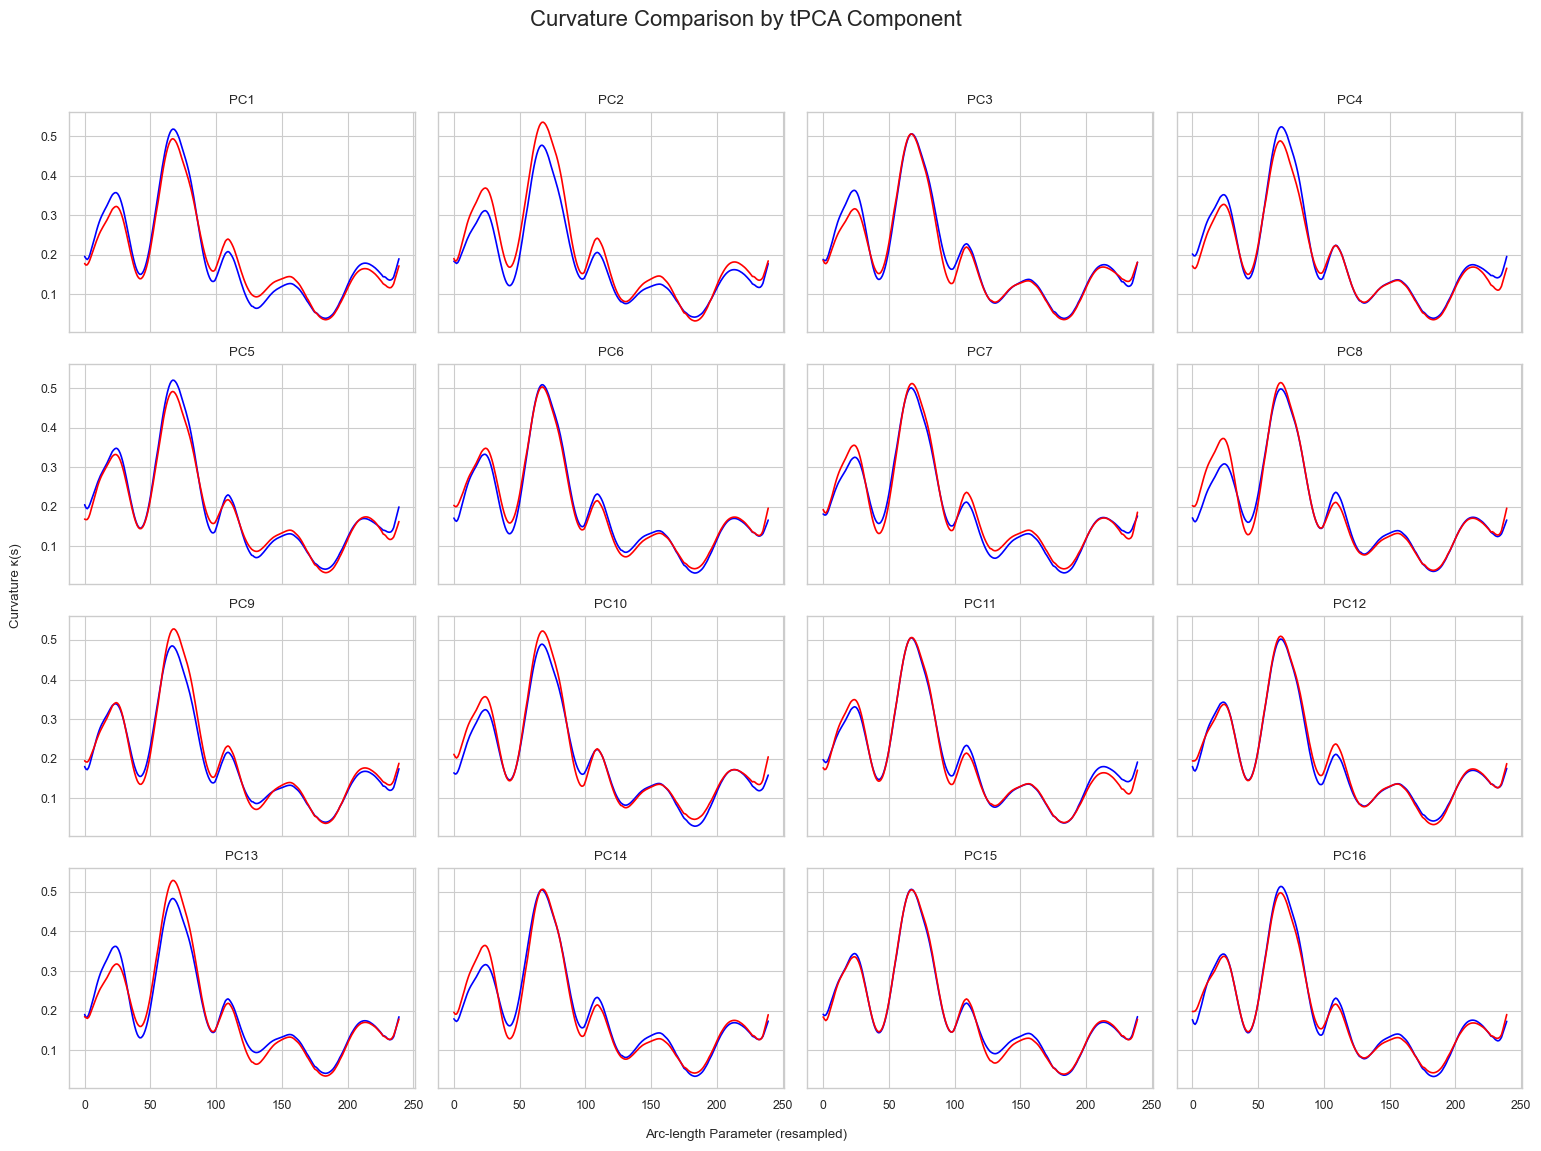

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# 参数
n_components = 16  # 总主成分数
n_cols = 4         # 每行放几个子图
n_rows = int(np.ceil(n_components / n_cols))  # 自动计算行数

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]

    scores = tangent_projected_data[:, pc_index]
    threshold = np.median(scores)

    high_idx = scores > threshold
    low_idx = scores <= threshold

    mean_kappa_high = np.mean(f_weighted_unwrapped[:, high_idx], axis=1)
    mean_kappa_low = np.mean(f_weighted_unwrapped[:, low_idx], axis=1)

    ax.plot(mean_kappa_low, label='Low', color='blue')
    ax.plot(mean_kappa_high, label='High', color='red')
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(True)

# 去除多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# 统一标签与布局
fig.suptitle('Curvature Comparison by tPCA Component', fontsize=16)
fig.text(0.5, 0.04, 'Arc-length Parameter (resampled)', ha='center')
fig.text(0.04, 0.5, 'Curvature κ(s)', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


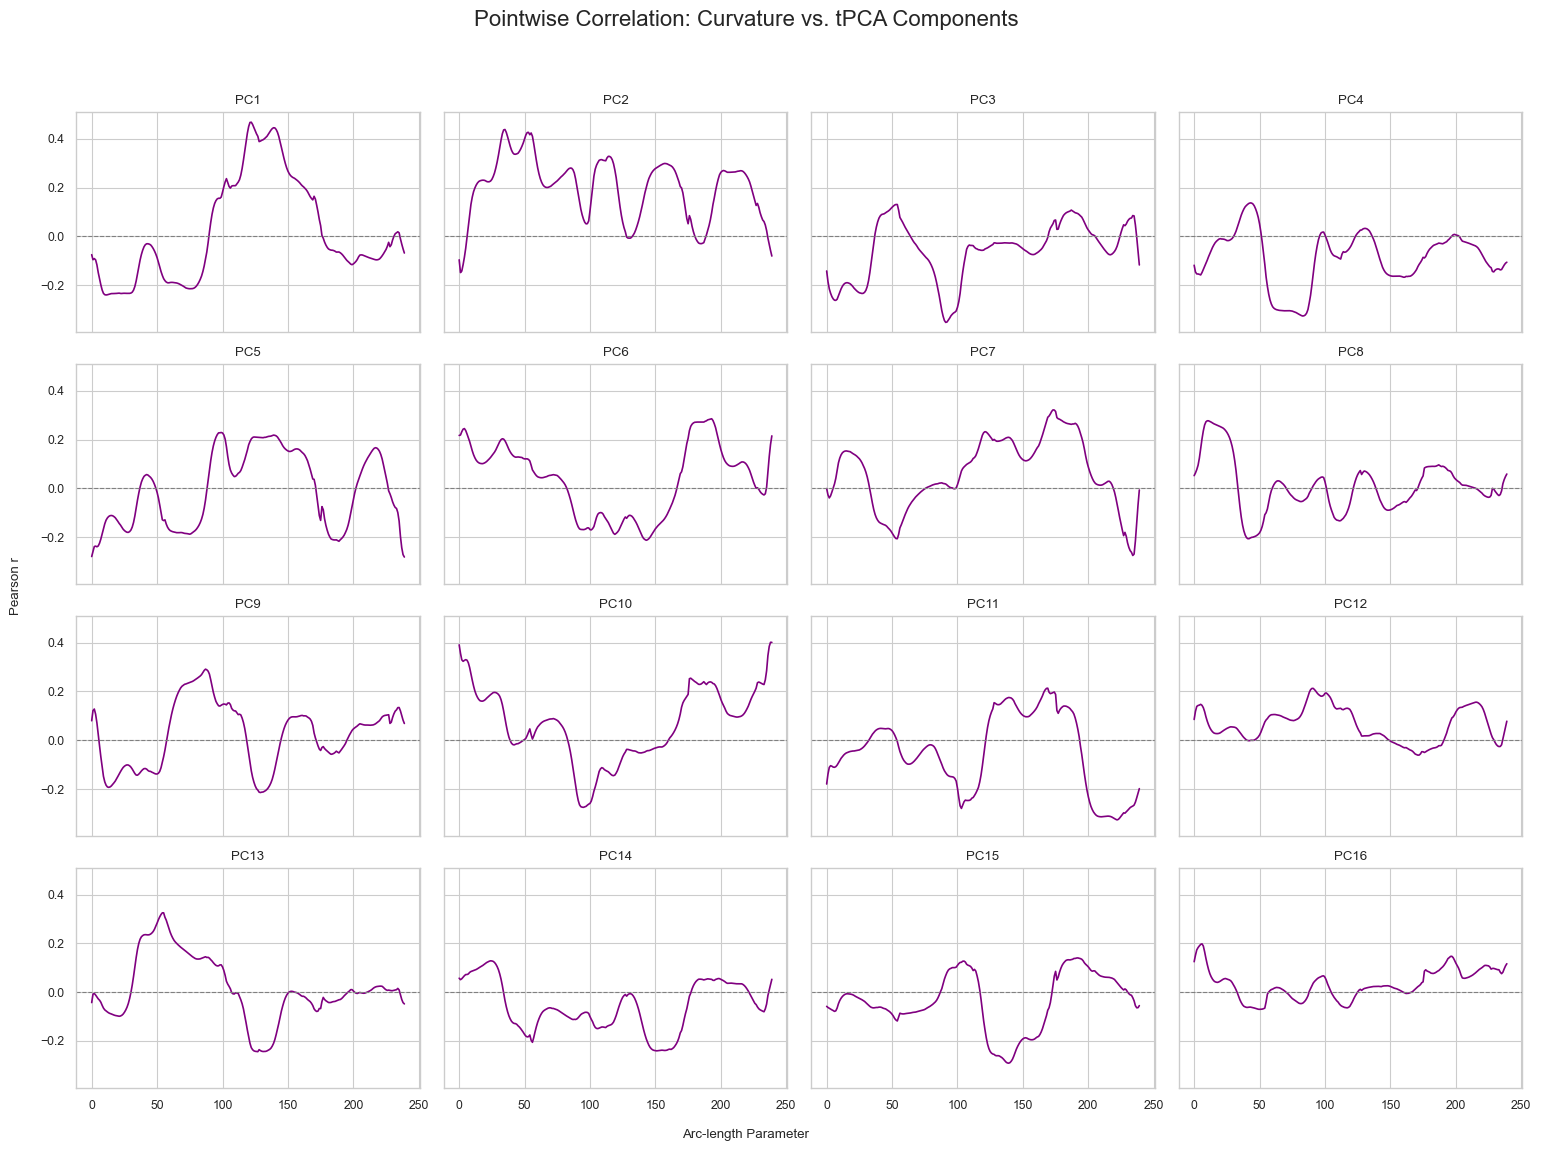

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# 参数
n_components = 16
n_cols = 4
n_rows = int(np.ceil(n_components / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=True, sharey=True)

for pc_index in range(n_components):
    ax = axes.flat[pc_index]
    pc_scores = tangent_projected_data[:, pc_index]

    corrs = []
    for j in range(f_weighted_unwrapped.shape[0]):
        r, _ = pearsonr(pc_scores, f_weighted_unwrapped[j, :])
        corrs.append(r)

    corrs = np.array(corrs)

    ax.plot(corrs, color='purple')
    ax.axhline(0, linestyle='--', color='gray', linewidth=0.8)
    ax.set_title(f'PC{pc_index + 1}')
    ax.grid(True)

# 去除多余子图
for i in range(n_components, n_rows * n_cols):
    fig.delaxes(axes.flat[i])

# 总体标签与布局
fig.suptitle('Pointwise Correlation: Curvature vs. tPCA Components', fontsize=16)
fig.text(0.5, 0.04, 'Arc-length Parameter', ha='center')
fig.text(0.04, 0.5, 'Pearson r', va='center', rotation='vertical')
fig.tight_layout(rect=[0.05, 0.05, 1, 0.95])

plt.show()


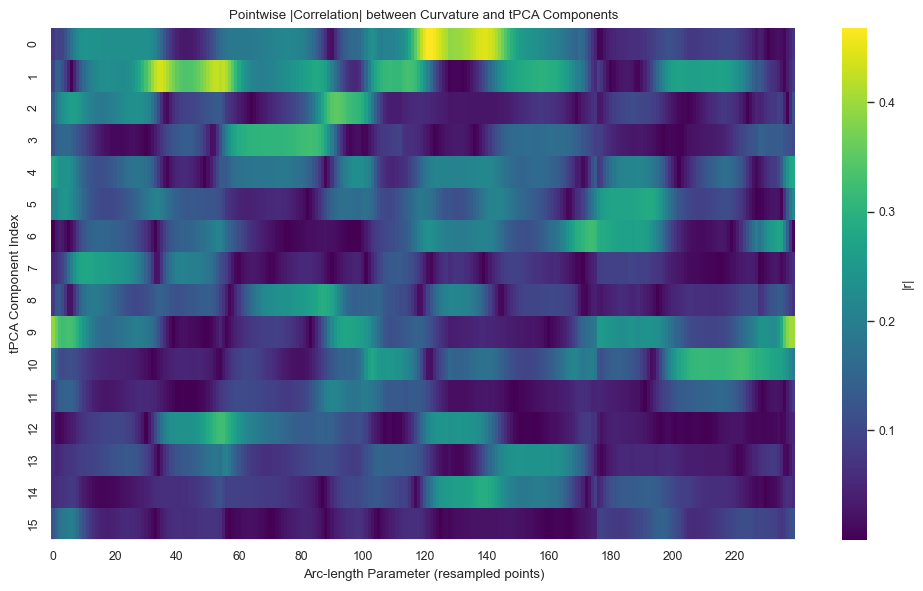

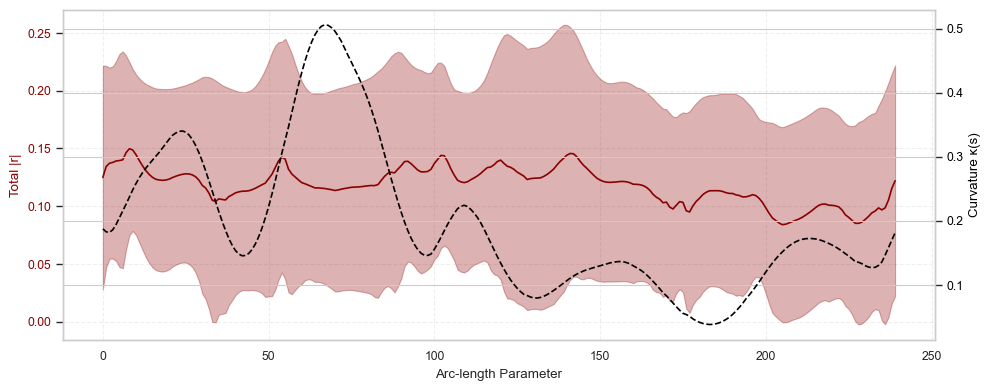

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

# Step 1: 构建相关矩阵 R (n_points, n_components)
n_components = tangent_projected_data.shape[1]
n_points = f_weighted_unwrapped.shape[0]
R = np.zeros((n_points, n_components))

for pc_index in range(n_components):
    pc_scores = tangent_projected_data[:, pc_index]
    for j in range(n_points):
        r, _ = pearsonr(pc_scores, f_weighted_unwrapped[j, :])
        R[j, pc_index] = r

# Step 2: 计算每个点的影响模式
# 模式强度特征
abs_R = np.abs(R)
max_r = np.max(abs_R, axis=1)
mean_r = np.mean(abs_R, axis=1)
std_r = np.std(abs_R, axis=1)


# Step 4: 可视化热图
plt.figure(figsize=(10, 6))
sns.heatmap(abs_R.T, cmap='viridis', cbar_kws={'label': '|r|'}, xticklabels=20)
plt.axhline(y=n_components, color='white', linewidth=2)
plt.xlabel("Arc-length Parameter (resampled points)")
plt.ylabel("tPCA Component Index")
plt.title("Pointwise |Correlation| between Curvature and tPCA Components")
plt.tight_layout()
plt.show()

# Step 5: 计算每个点的整体影响强度
influence_score = np.sum(abs_R, axis=1)/tPCA_N_COMPONENTS  # shape: (n_points,)
influence_std = np.std(abs_R, axis=1)  # shape: (n_points,)

# 可视化影响强度曲线 + 曲率均值 + 标准差区域
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

# 主图：influence_score（红线）+ 标准差阴影
x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(
    x,
    influence_score - influence_std,
    influence_score + influence_std,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

# 辅助图：曲率均值
ax2.plot(f_weighted_unwrapped.mean(axis=1), color='black', linestyle='--', label='Mean κ(s)')

# 标签与美化
ax1.set_xlabel("Arc-length Parameter")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Curvature κ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(True, linestyle='--', alpha=0.3)

fig.tight_layout()
plt.show()



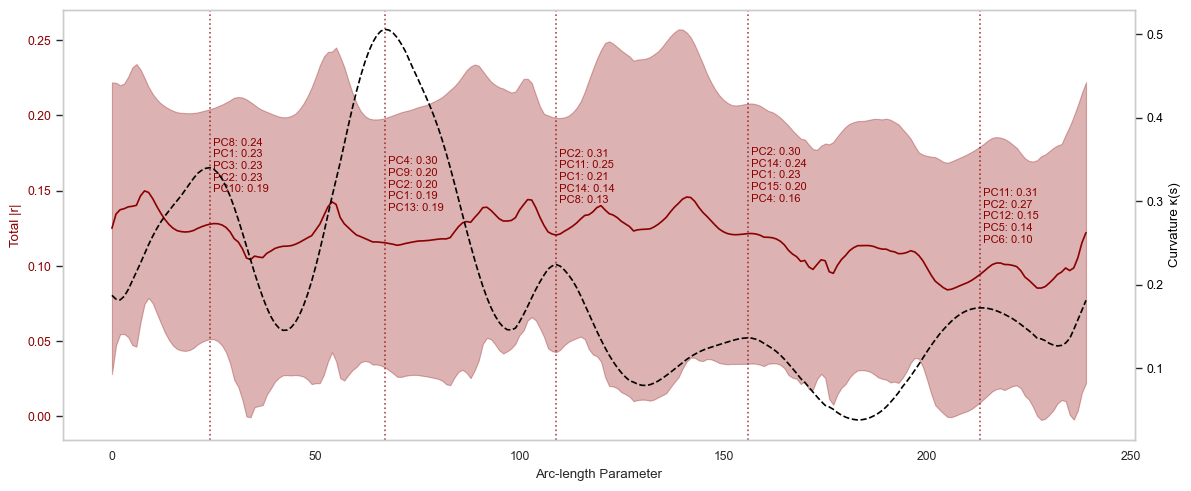

In [47]:
from scipy.signal import find_peaks

# Step 5: 计算每个点的整体影响强度
influence_score = np.sum(abs_R, axis=1) / tPCA_N_COMPONENTS  # shape: (n_points,)
influence_std = np.std(abs_R, axis=1)  # shape: (n_points,)

# Step 6: 找到平均曲率的峰值位置
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)

# Step 7: 找出每个峰值位置最强的前5个 tPC 分量及其影响强度
topk = 5
top_tpcs = np.argsort(abs_R[peaks], axis=1)[:, -topk:][:, ::-1]  # shape: (n_peaks, 5)
top_vals = np.take_along_axis(abs_R[peaks], top_tpcs, axis=1)   # shape: (n_peaks, 5)

# 可视化
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(
    x,
    influence_score - influence_std,
    influence_score + influence_std,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

ax2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')

# Step 8: 标注每个峰值的前5个影响最大PC
for i, idx in enumerate(peaks):
    ax1.axvline(idx, color='darkred', linestyle=':', alpha=0.7)
    label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
    ax1.text(idx, influence_score[idx] + 0.02, label_text,
             color='darkred', fontsize=8, ha='left', va='bottom')

# 标签与美化
ax1.set_xlabel("Arc-length Parameter")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Curvature κ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


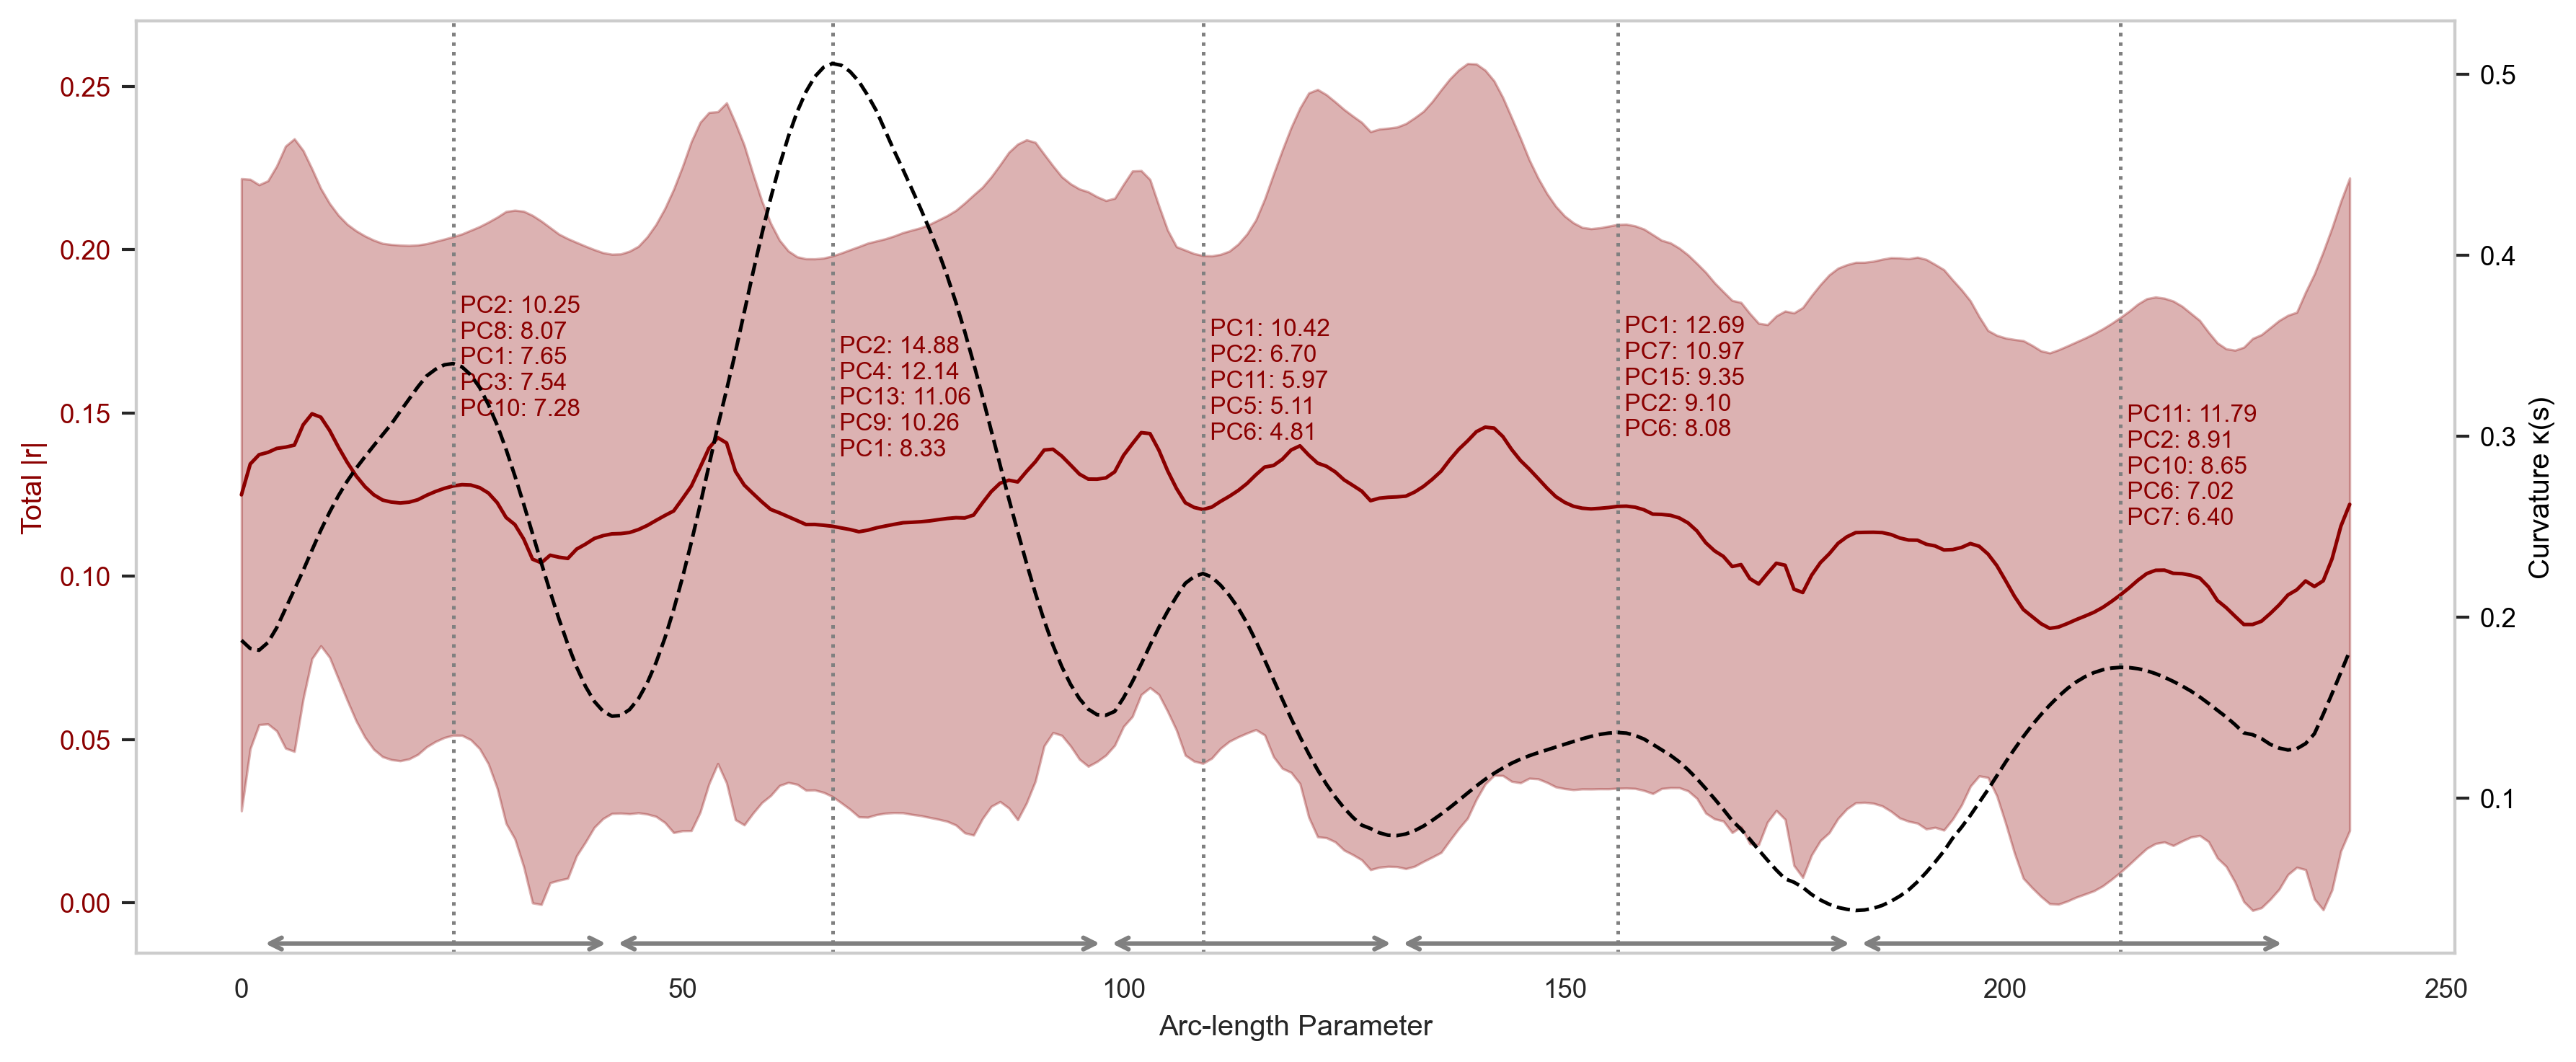

In [54]:
from scipy.signal import find_peaks

# Step 5: 计算每个点的整体影响强度
influence_score = np.sum(abs_R, axis=1) / tPCA_N_COMPONENTS
influence_std = np.std(abs_R, axis=1)

# Step 6: 计算平均曲率并找出波峰与波谷
mean_curvature = f_weighted_unwrapped.mean(axis=1)
peaks, _ = find_peaks(mean_curvature, distance=5)
valleys, _ = find_peaks(-mean_curvature, distance=5)

# Step 7: 对每个波峰，在其相邻波谷范围内整合abs_R
topk = 5
top_tpcs = []
top_vals = []

for peak in peaks:
    # 找左波谷：小于当前peak的最大valley
    left_valley_candidates = valleys[valleys < peak]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0

    # 找右波谷：大于当前peak的最小valley
    right_valley_candidates = valleys[valleys > peak]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R.shape[0] - 1

    # 在区间 [left, right] 内对每个tPC累加影响
    region_r = abs_R[left:right + 1, :]  # shape: (region_len, n_components)
    summed_r = np.sum(region_r, axis=0)  # shape: (n_components,)

    # 找出 top-k tPC
    top_pc_indices = np.argsort(summed_r)[-topk:][::-1]
    top_pc_values = summed_r[top_pc_indices]

    top_tpcs.append(top_pc_indices)
    top_vals.append(top_pc_values)

top_tpcs = np.array(top_tpcs)
top_vals = np.array(top_vals)

# 可视化
fig = plt.figure(figsize=(12, 5),dpi=300)
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

x = np.arange(len(influence_score))
ax1.plot(x, influence_score, color='darkred', label='Mean |r|')
ax1.fill_between(
    x,
    influence_score - influence_std,
    influence_score + influence_std,
    color='darkred',
    alpha=0.3,
    label='±1 std'
)

ax2.plot(mean_curvature, color='black', linestyle='--', label='Mean κ(s)')

# 标注每个峰值区间的前5个影响最大tPC及其影响值
for i, idx in enumerate(peaks):
    # 取出区间左右边界
    left_valley_candidates = valleys[valleys < idx]
    left = left_valley_candidates[-1] if len(left_valley_candidates) > 0 else 0
    right_valley_candidates = valleys[valleys > idx]
    right = right_valley_candidates[0] if len(right_valley_candidates) > 0 else abs_R.shape[0] - 1

    # 竖线标注峰值
    ax1.axvline(idx, color='gray', linestyle=':', alpha=1)

    # 箭头/横线：从 left 到 right，紧贴 x 轴底部
    y_arrow = ax1.get_ylim()[0] + 0.01 * (ax1.get_ylim()[1] - ax1.get_ylim()[0])
    ax1.annotate('', xy=(right, y_arrow), xytext=(left, y_arrow),
                 arrowprops=dict(arrowstyle='<->', color='gray', lw=1.5), annotation_clip=False)

    # 文字标注
    label_text = '\n'.join([f" PC{pc+1}: {val:.2f}" for pc, val in zip(top_tpcs[i], top_vals[i])])
    ax1.text(idx, influence_score[idx] + 0.02, label_text,
             color='darkred', fontsize=8, ha='left', va='bottom')

# 图美化
ax1.set_xlabel("Arc-length Parameter")
ax1.set_ylabel("Total |r|", color='darkred')
ax2.set_ylabel("Curvature κ(s)", color='black')
ax1.tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='black')
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()


- PC1让坐标在哪个方向（可能不一定是XYZ正方向）上变化最大？
- PC1让哪个段（可能用landmarks分段？）上变化最大？

```
obj = obj_plain
print("gamma:", hasattr(obj, 'gam'))
if hasattr(obj, 'gam'):
    print("gamma shape:", obj.gam.shape)
```

gamma: True
gamma shape: (240, 91)

```
import pickle

# 保存字典为 pkl 文件
output_path = "vtk_data_dict.pkl"
with open(output_path, "wb") as f:
    pickle.dump(vtk_data_dict, f)

print(f"字典已保存为: {output_path}")
```
